<a href="https://colab.research.google.com/github/laiky2506/ace_resource/blob/main/Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A team of plantation planners are concerned about the yield of oil palm trees, which seems to
fluctuate. They have collected a set of data and needed help in analysing on how external
factors influence fresh fruit bunch (FFB) yield. Some experts are of opinion that the flowering of
oil palm tree determines the FFB yield, and are linked to the external factors. Perform the
analysis, which requires some study on the background of oil palm tree physiology. 

In [ ]:
!pip install eli5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from prettytable import PrettyTable
from sklearn.feature_selection import mutual_info_regression
from scipy import optimize
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import eli5
from eli5.sklearn import PermutationImportance
SEED = 1234

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
  
def detect_outlier(D):
    threshold=3
    outliers=[]
    D_mean = np.mean(D)
    D_std =np.std(D)
    for d in D:
        z_score= (d - D_mean)/D_std 
        if np.abs(z_score) > threshold:
            outliers.append(d)
    return outliers

In [ ]:
data = pd.read_csv(r"https://docs.google.com/spreadsheets/d/e/2PACX-1vRAOkG1Ftc9d9y8rSPd6CdPEW4y6UN_6alUf4WWwRsQmn4u6BK-eqKQfSCt6_hpbS1JzmRv-FrWI-MM/pub?output=csv")
data.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [ ]:
data.describe()


,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,527.646923,26.849918,21.379231,33.851538,188.980769,24.753846,793404.491565,1.602231
std,57.367844,0.651413,0.688971,1.079638,80.237210,1.239289,34440.893854,0.281751
min,380.700000,25.158065,18.900000,31.100000,2.000000,21.000000,683431.944400,1.080000
25%,488.625000,26.442285,21.000000,33.100000,140.300000,24.000000,768966.949100,1.390000
50%,538.300000,26.930645,21.500000,33.900000,182.150000,25.000000,790036.158050,1.585000
75%,571.025000,27.270726,21.800000,34.600000,226.100000,26.000000,821989.235250,1.807500
max,647.300000,28.580000,22.600000,36.000000,496.100000,27.000000,882254.225400,2.270000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           130 non-null    object 
 1   SoilMoisture   130 non-null    float64
 2   Average_Temp   130 non-null    float64
 3   Min_Temp       130 non-null    float64
 4   Max_Temp       130 non-null    float64
 5   Precipitation  130 non-null    float64
 6   Working_days   130 non-null    int64  
 7   HA_Harvested   130 non-null    float64
 8   FFB_Yield      130 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.3+ KB


In [ ]:
data['Date'] = pd.to_datetime(data['Date'],format="%d.%m.%Y")
data['Month'] = data['Date'].dt.month
data['Month']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           130 non-null    datetime64[ns]
 1   SoilMoisture   130 non-null    float64       
 2   Average_Temp   130 non-null    float64       
 3   Min_Temp       130 non-null    float64       
 4   Max_Temp       130 non-null    float64       
 5   Precipitation  130 non-null    float64       
 6   Working_days   130 non-null    int64         
 7   HA_Harvested   130 non-null    float64       
 8   FFB_Yield      130 non-null    float64       
 9   Month          130 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 10.3 KB


In [ ]:
X = data[["Month","SoilMoisture","Average_Temp","Min_Temp","Max_Temp","Precipitation","Working_days","HA_Harvested"]]
y = data["FFB_Yield"]

In [ ]:
mi_scores = make_mi_scores(X, y)
mi_scores

Month            0.529890
HA_Harvested     0.201858
Precipitation    0.127073
Min_Temp         0.078946
SoilMoisture     0.066543
Average_Temp     0.000000
Max_Temp         0.000000
Working_days     0.000000
Name: MI Scores, dtype: float64

In [ ]:
Xy_corr = []
for x in X:
  stat, p = stats.pearsonr(X[x], y)
  Xy_corr.append({'col':x,'stat':stat})
Xy_corr.sort(key=lambda x: x.get('stat'), reverse=True)

for row in Xy_corr:
    print(row['col'],":",round(row['stat'],4))
    

Month : 0.6713
Precipitation : 0.2896
Working_days : 0.1164
Min_Temp : 0.1038
SoilMoisture : -0.0032
Average_Temp : -0.0055
Max_Temp : -0.0712
HA_Harvested : -0.3502


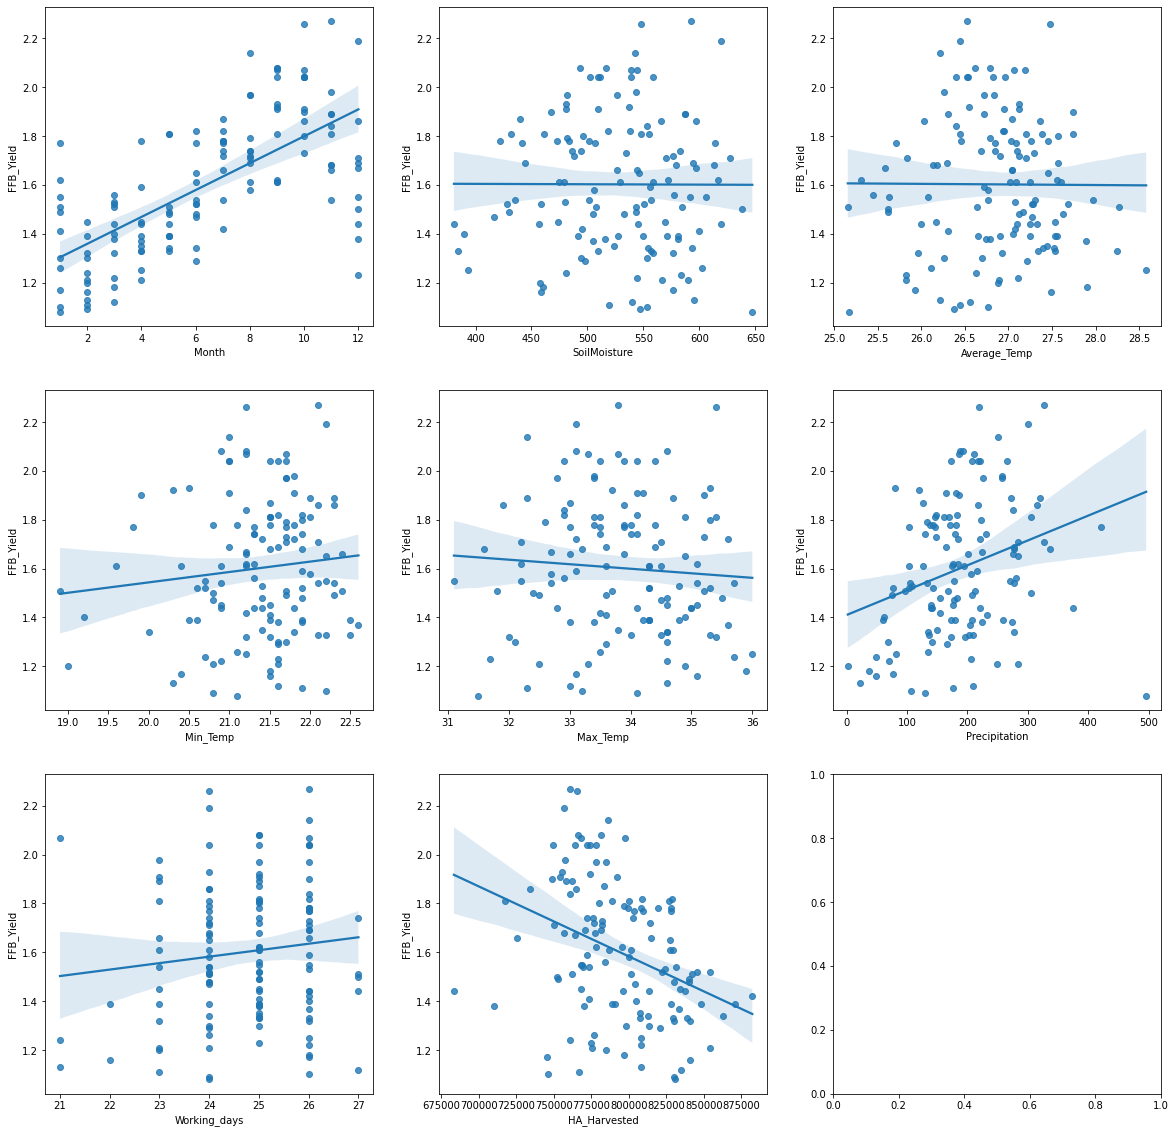

In [ ]:
fig, axis = plt.subplots(3,3,figsize=(20, 20))
for i,d in enumerate(X.columns):
  sns.regplot(x=X[d], y=y, ax=axis[int(i/3)][i%3])

In [ ]:
features = data[["Month","Precipitation","Min_Temp","SoilMoisture","HA_Harvested","FFB_Yield"]]

In [ ]:
print(features.shape)
for f in features:
    outlier = detect_outlier(features[f])
    for o in outlier:
        features = features.drop(features[features[f] == o].index)

print(features.shape)
label = features.pop("FFB_Yield")

(130, 6)
(125, 6)


In [ ]:
# One Hot Encoding, encode month
features = pd.get_dummies(features,columns=['Month'])
features

,Precipitation,Min_Temp,SoilMoisture,HA_Harvested,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,184.4,21.3,616.4,777778.3951,1,0,0,0,0,0,0,0,0,0,0,0
1,140.2,20.9,568.9,767988.2759,0,1,0,0,0,0,0,0,0,0,0,0
2,280.4,21.3,577.6,783951.9231,0,0,1,0,0,0,0,0,0,0,0,0
3,173.3,20.6,581.1,788987.0504,0,0,0,1,0,0,0,0,0,0,0,0
4,140.6,20.9,545.4,813659.7222,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,165.6,21.6,498.2,820758.9147,0,0,0,0,0,1,0,0,0,0,0,0
126,154.7,21.2,494.7,882254.2254,0,0,0,0,0,0,1,0,0,0,0,0
127,127.2,20.4,478.8,829488.8199,0,0,0,0,0,0,0,1,0,0,0,0
128,180.6,21.0,481.1,792101.0471,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(features), np.array(label), test_size = 0.2, random_state = SEED)

In [ ]:
import sklearn.preprocessing as preprocessing

standardizer = preprocessing.StandardScaler()
standardizer.fit(X_train)
X_train = standardizer.transform(X_train)
X_test = standardizer.transform(X_test)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
linreg =LinearRegression()
linreg.fit(X_train, y_train)
print("coefficient: ",linreg.coef_)
print("interception: ",linreg.intercept_)

coefficient:  [ 0.07693113 -0.01000218 -0.01585295 -0.05907044 -0.04586165 -0.08544012
 -0.05950451 -0.06045448  0.00117635  0.00227906  0.04518951  0.03903695
  0.08292836  0.0821046   0.01721357 -0.02237026]
interception:  1.6183


R2 score: 0.32179586825469775
Mean Absolute Error: 0.1643550463065027
Mean Squared Error: 0.039285489766486756
Root Mean Squared Error: 0.19820567541442086


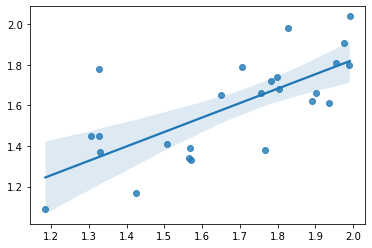

In [ ]:
y_pred = linreg.predict(X_test)
sns.regplot(x=y_pred, y=y_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
perm = PermutationImportance(linreg).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
0.1803 ± 0.0339,Month_9
0.1753 ± 0.0408,Month_2
0.1636 ± 0.0335,Precipitation
0.1427 ± 0.0631,Month_10
0.0856 ± 0.0474,HA_Harvested
0.0819 ± 0.0426,Month_4
0.0684 ± 0.0218,Month_3
0.0625 ± 0.0297,Month_7
0.0494 ± 0.0170,Month_8
0.0444 ± 0.0223,Month_1


## Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=SEED, max_iter=1000)
regr.fit(X_train, y_train)

MLPRegressor(max_iter=1000, random_state=1234)

R2 score: 0.08250948253878798
Mean Absolute Error: 0.1935579388918221
Mean Squared Error: 0.05314633551673397
Root Mean Squared Error: 0.2305348900204348


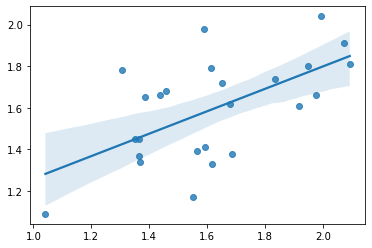

In [ ]:
y_pred = regr.predict(X_test)
sns.regplot(x=y_pred, y=y_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
perm = PermutationImportance(regr).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
1.6446 ± 0.5538,Month_10
1.5057 ± 0.4039,Month_9
1.1861 ± 0.1708,Month_8
1.0619 ± 0.1459,Month_7
0.8399 ± 0.1082,Month_6
0.7458 ± 0.1870,Month_5
0.7280 ± 0.1273,Precipitation
0.6665 ± 0.2460,Month_11
0.6520 ± 0.5178,HA_Harvested
0.6204 ± 0.0974,Month_3


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(n_estimators=128, random_state=SEED)
rfreg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=128, random_state=1234)

R2 score: 0.602766519256179
Mean Absolute Error: 0.11365625000000001
Mean Squared Error: 0.023010051269531196
Root Mean Squared Error: 0.1516906433157009


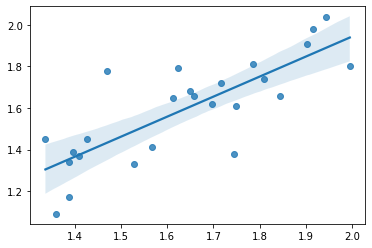

In [ ]:
y_pred = rfreg.predict(X_test)
sns.regplot(x=y_pred, y=y_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
perm = PermutationImportance(rfreg).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
0.4652 ± 0.1608,HA_Harvested
0.2766 ± 0.0617,Precipitation
0.1665 ± 0.0486,Month_2
0.1393 ± 0.0393,SoilMoisture
0.0644 ± 0.0191,Month_10
0.0506 ± 0.0157,Min_Temp
0.0430 ± 0.0190,Month_9
0.0353 ± 0.0144,Month_7
0.0320 ± 0.0101,Month_3
0.0212 ± 0.0046,Month_1


## XGB Regressor

In [ ]:
from xgboost import XGBRegressor
XGBReg = XGBRegressor(n_estimators=500)
XGBReg.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)],
             verbose=False)

[08:15:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=500)

R2 score: 0.5250146793208281
Mean Absolute Error: 0.13939620285034182
Mean Squared Error: 0.027513885689184746
Root Mean Squared Error: 0.1658731011622582


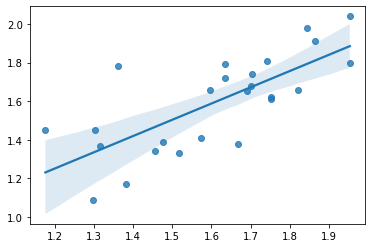

In [ ]:
y_pred = XGBReg.predict(X_test)
sns.regplot(x=y_pred, y=y_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
perm = PermutationImportance(XGBReg).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = features.columns.tolist())

Weight,Feature
0.3299 ± 0.0442,HA_Harvested
0.2842 ± 0.0414,Precipitation
0.2414 ± 0.0854,Month_2
0.0855 ± 0.0267,SoilMoisture
0.0828 ± 0.0222,Month_9
0.0713 ± 0.0223,Month_3
0.0701 ± 0.0355,Month_10
0.0581 ± 0.0404,Month_4
0.0279 ± 0.0236,Month_1
0.0192 ± 0.0064,Min_Temp


## Tensorflow : Sequential

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 1,257
Trainable params: 1,257
Non-trainabl

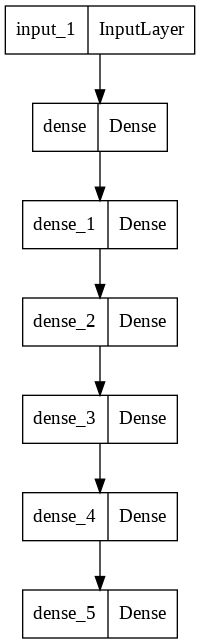

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(features.shape[1],)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=['mse','mae'])
cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=32)
history = model.fit(X_train,y_train, validation_data=(X_test, y_test), batch_size=32,epochs=1000,callbacks=[cb])

Epoch 1/1000
4/4 [==============================] - 1s 73ms/step - loss: 2.1429 - mse: 2.1429 - mae: 1.4189 - val_loss: 1.9936 - val_mse: 1.9936 - val_mae: 1.3699
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.9314 - mse: 1.9314 - mae: 1.3390 - val_loss: 1.7854 - val_mse: 1.7854 - val_mae: 1.2857
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.7318 - mse: 1.7318 - mae: 1.2583 - val_loss: 1.5877 - val_mse: 1.5877 - val_mae: 1.2000
Epoch 4/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.5544 - mse: 1.5544 - mae: 1.1782 - val_loss: 1.4042 - val_mse: 1.4042 - val_mae: 1.1134
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.3846 - mse: 1.3846 - mae: 1.0976 - val_loss: 1.2437 - val_mse: 1.2437 - val_mae: 1.0296
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 1.2205 - mse: 1.2205 - mae: 1.0123 - val_loss: 1.0935 - val_mse: 1.0935 - val_mae: 0.9419
Epoch 7/1000
4/4 [====

R2 score: -0.5325584235482006
Mean Absolute Error: 0.20374722127914432
Mean Squared Error: 0.0887746114284314
Root Mean Squared Error: 0.29795068623587934


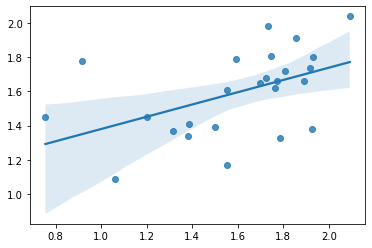

In [ ]:
y_pred = model.predict(X_test)
sns.regplot(x=y_pred, y=y_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


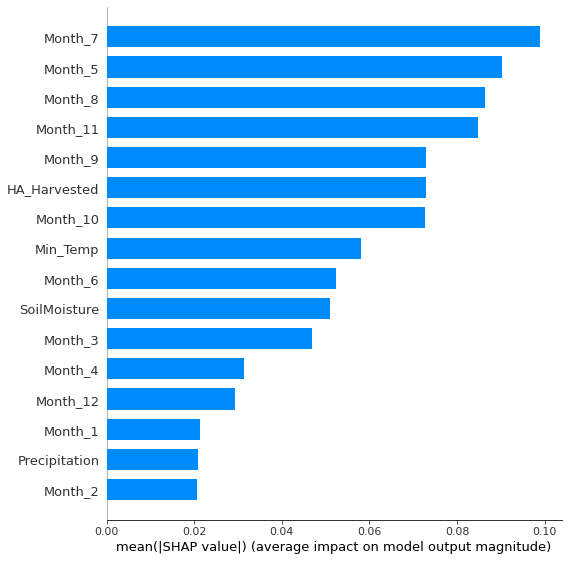

In [ ]:
!pip install shap
import shap
DE = shap.DeepExplainer(model, X_train)
shap_values = DE.shap_values(X_test, check_additivity=False)

shap.initjs()
shap.summary_plot(
    shap_values[0], 
    X_test,
    feature_names = features.columns.tolist(),
    max_display=50,
    plot_type='bar')